<a href="https://colab.research.google.com/github/iacopoooo/Tesi/blob/main/Coab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ==============================================================================
#                    NOTEBOOK / SCRIPT UNICO CON RESA IDENTICA
# ==============================================================================

# ------------------------------------------------------------------------------
# 0. STANDARDIZZAZIONE AMBIENTE, BACKEND, STILE, SEED
# ------------------------------------------------------------------------------
import os, sys, random
os.environ["PYTHONHASHSEED"] = "42"   # rende deterministici gli hash di Python

import numpy as np
import pandas as pd

# Seed globali
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Matplotlib/Seaborn: backend, DPI, font, tema coerenti
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Rileva se sei in Colab
IN_COLAB = "COLAB_RELEASE_TAG" in os.environ or "COLAB_GPU" in os.environ

# In Colab manteniamo inline, in PyCharm forziamo Agg (render identico a file)
if not IN_COLAB:
    # In PyCharm (o script), niente finestra interattiva: render su file/figura identico
    matplotlib.use("Agg")

# DPI e stile coerenti
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.bbox": "tight",
    "figure.figsize": (10, 6),
    "font.family": "DejaVu Sans",  # disponibile ovunque
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})

# Tema e palette fissi (evita differenze tra versioni)
sns.set_theme(style="whitegrid")
sns.set_palette(sns.color_palette(["#4E79A7", "#F28E2B", "#E15759", "#76B7B2",
                                  "#59A14F", "#EDC948", "#B07AA1", "#FF9DA7",
                                  "#9C755F", "#BAB0AC"]))

# (Opzionale) alta risoluzione inline in notebook
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip and IN_COLAB:
        ip.run_line_magic("config", "InlineBackend.figure_format = 'retina'")
except Exception:
    pass


In [8]:
# ------------------------------------------------------------------------------
# 1. IMPORT LIBRERIE ML E STAMPA VERSIONI
# ------------------------------------------------------------------------------
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_recall_fscore_support)
from sklearn.exceptions import ConvergenceWarning
import sklearn

print("== Librerie importate con successo ==")
print(f"[VERSIONS] pandas={pd.__version__} numpy={np.__version__} "
      f"matplotlib={matplotlib.__version__} seaborn={sns.__version__} "
      f"scikit-learn={sklearn.__version__}")
print(f"IN_COLAB={IN_COLAB}")

== Librerie importate con successo ==
[VERSIONS] pandas=2.2.2 numpy=2.0.2 matplotlib=3.10.0 seaborn=0.13.2 scikit-learn=1.6.1
IN_COLAB=True


In [9]:
# ------------------------------------------------------------------------------
# 2. CARICAMENTO E PRE-PROCESSING OTTIMIZZATO (CONSISTENTE)
# ------------------------------------------------------------------------------
file_path = '/content/cicids2017.csv' if IN_COLAB else 'cicids2017.csv'
print(f"\nCaricamento e campionamento ottimizzato del file: {file_path}")

try:
    # Iterator + sample deterministico su ciascun chunk
    df_iter = pd.read_csv(file_path, iterator=True, chunksize=50_000)
    # Generator expression (no lista intermedia): minor uso RAM e stessa casualità
    df = pd.concat((chunk.sample(frac=0.10, random_state=SEED) for chunk in df_iter),
                   ignore_index=True)
    print("Dataset caricato e campionato con successo.")
except Exception as e:
    print(f"Si è verificato un errore durante il caricamento: {e}")
    raise

# Pulizia nomi colonne identica ovunque
df.columns = (df.columns.str.strip()
                         .str.lower()
                         .str.replace(' ', '_')
                         .str.replace('[^a-zA-Z0-9_]', '', regex=True))

if 'label' not in df.columns:
    raise ValueError("Colonna 'label' non trovata nel dataset dopo la pulizia dei nomi.")

print(f"Shape iniziale del campione: {df.shape}")
print(f"Distribuzione iniziale delle classi:\n{df['label'].value_counts()}\n")

# Separazione feature e target
X = df.drop('label', axis=1)
y_str = df['label']

# Conversione numerica coerente (valori non numerici -> NaN)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Gestione inf e NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Re-merge per controllo distribuzione
df_cleaned = pd.concat([X, y_str.reset_index(drop=True)], axis=1)
print(f"Distribuzione finale delle classi (dopo pulizia):\n{df_cleaned['label'].value_counts()}\n")

# Encoding label + scaling consistente
X = df_cleaned.drop('label', axis=1)
y_str = df_cleaned['label']

le = LabelEncoder()
y_enc = le.fit_transform(y_str)
class_names = le.classes_            # ordine delle classi (fisso)
class_index = np.arange(len(class_names))  # 0..C-1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split deterministici e stratificati (uguali per RF e MLP)
X_train, X_test, y_train_str, y_test_str = train_test_split(
    X_scaled, y_str, test_size=0.2, random_state=SEED, stratify=y_str
)
# Per il MLP usiamo le label encodate abbinando gli stessi indici dello split stringhe
y_train_enc = le.transform(y_train_str)
y_test_enc  = le.transform(y_test_str)

print("Dati pronti per l'addestramento.")


Caricamento e campionamento ottimizzato del file: /content/cicids2017.csv
Dataset caricato e campionato con successo.
Shape iniziale del campione: (69270, 79)
Distribuzione iniziale delle classi:
label
BENIGN              43941
DoS Hulk            23158
DoS GoldenEye        1030
DoS slowloris         584
DoS Slowhttptest      557
Name: count, dtype: int64

Distribuzione finale delle classi (dopo pulizia):
label
BENIGN              43941
DoS Hulk            23158
DoS GoldenEye        1030
DoS slowloris         584
DoS Slowhttptest      557
Name: count, dtype: int64

Dati pronti per l'addestramento.



--- Addestramento e Valutazione Random Forest ---

Accuratezza (RF): 99.89%

Rapporto di Classificazione (RF):
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00      8788
   DoS GoldenEye       1.00      0.99      0.99       206
        DoS Hulk       1.00      1.00      1.00      4632
DoS Slowhttptest       0.98      0.99      0.99       111
   DoS slowloris       0.99      0.99      0.99       117

        accuracy                           1.00     13854
       macro avg       0.99      0.99      0.99     13854
    weighted avg       1.00      1.00      1.00     13854



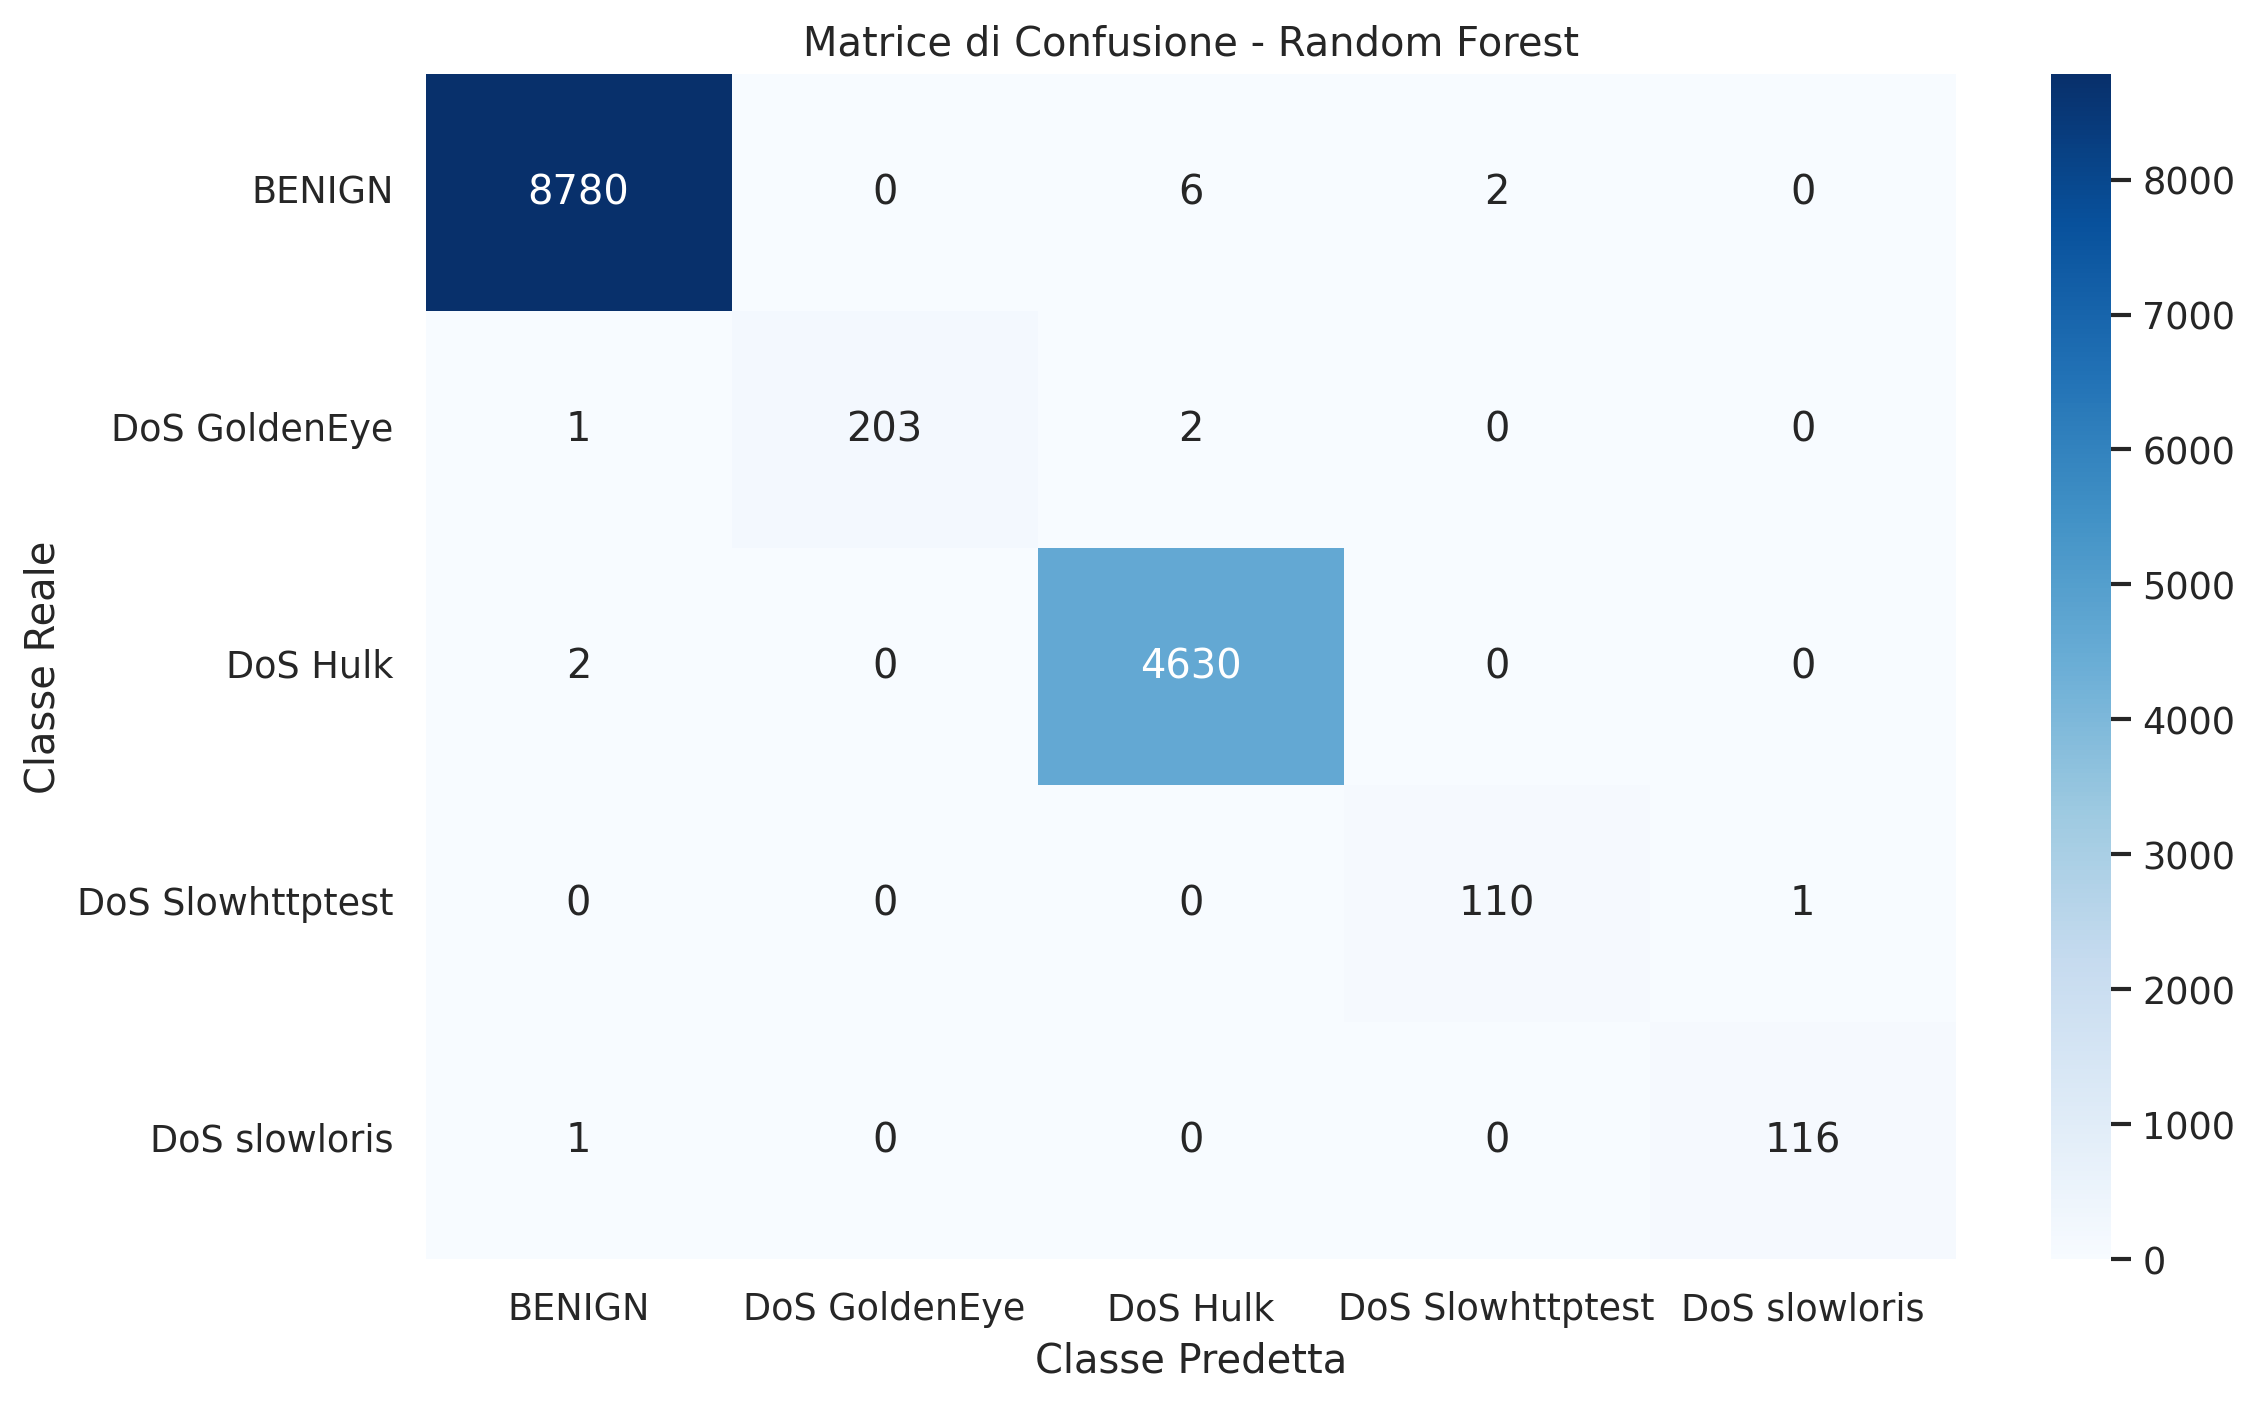

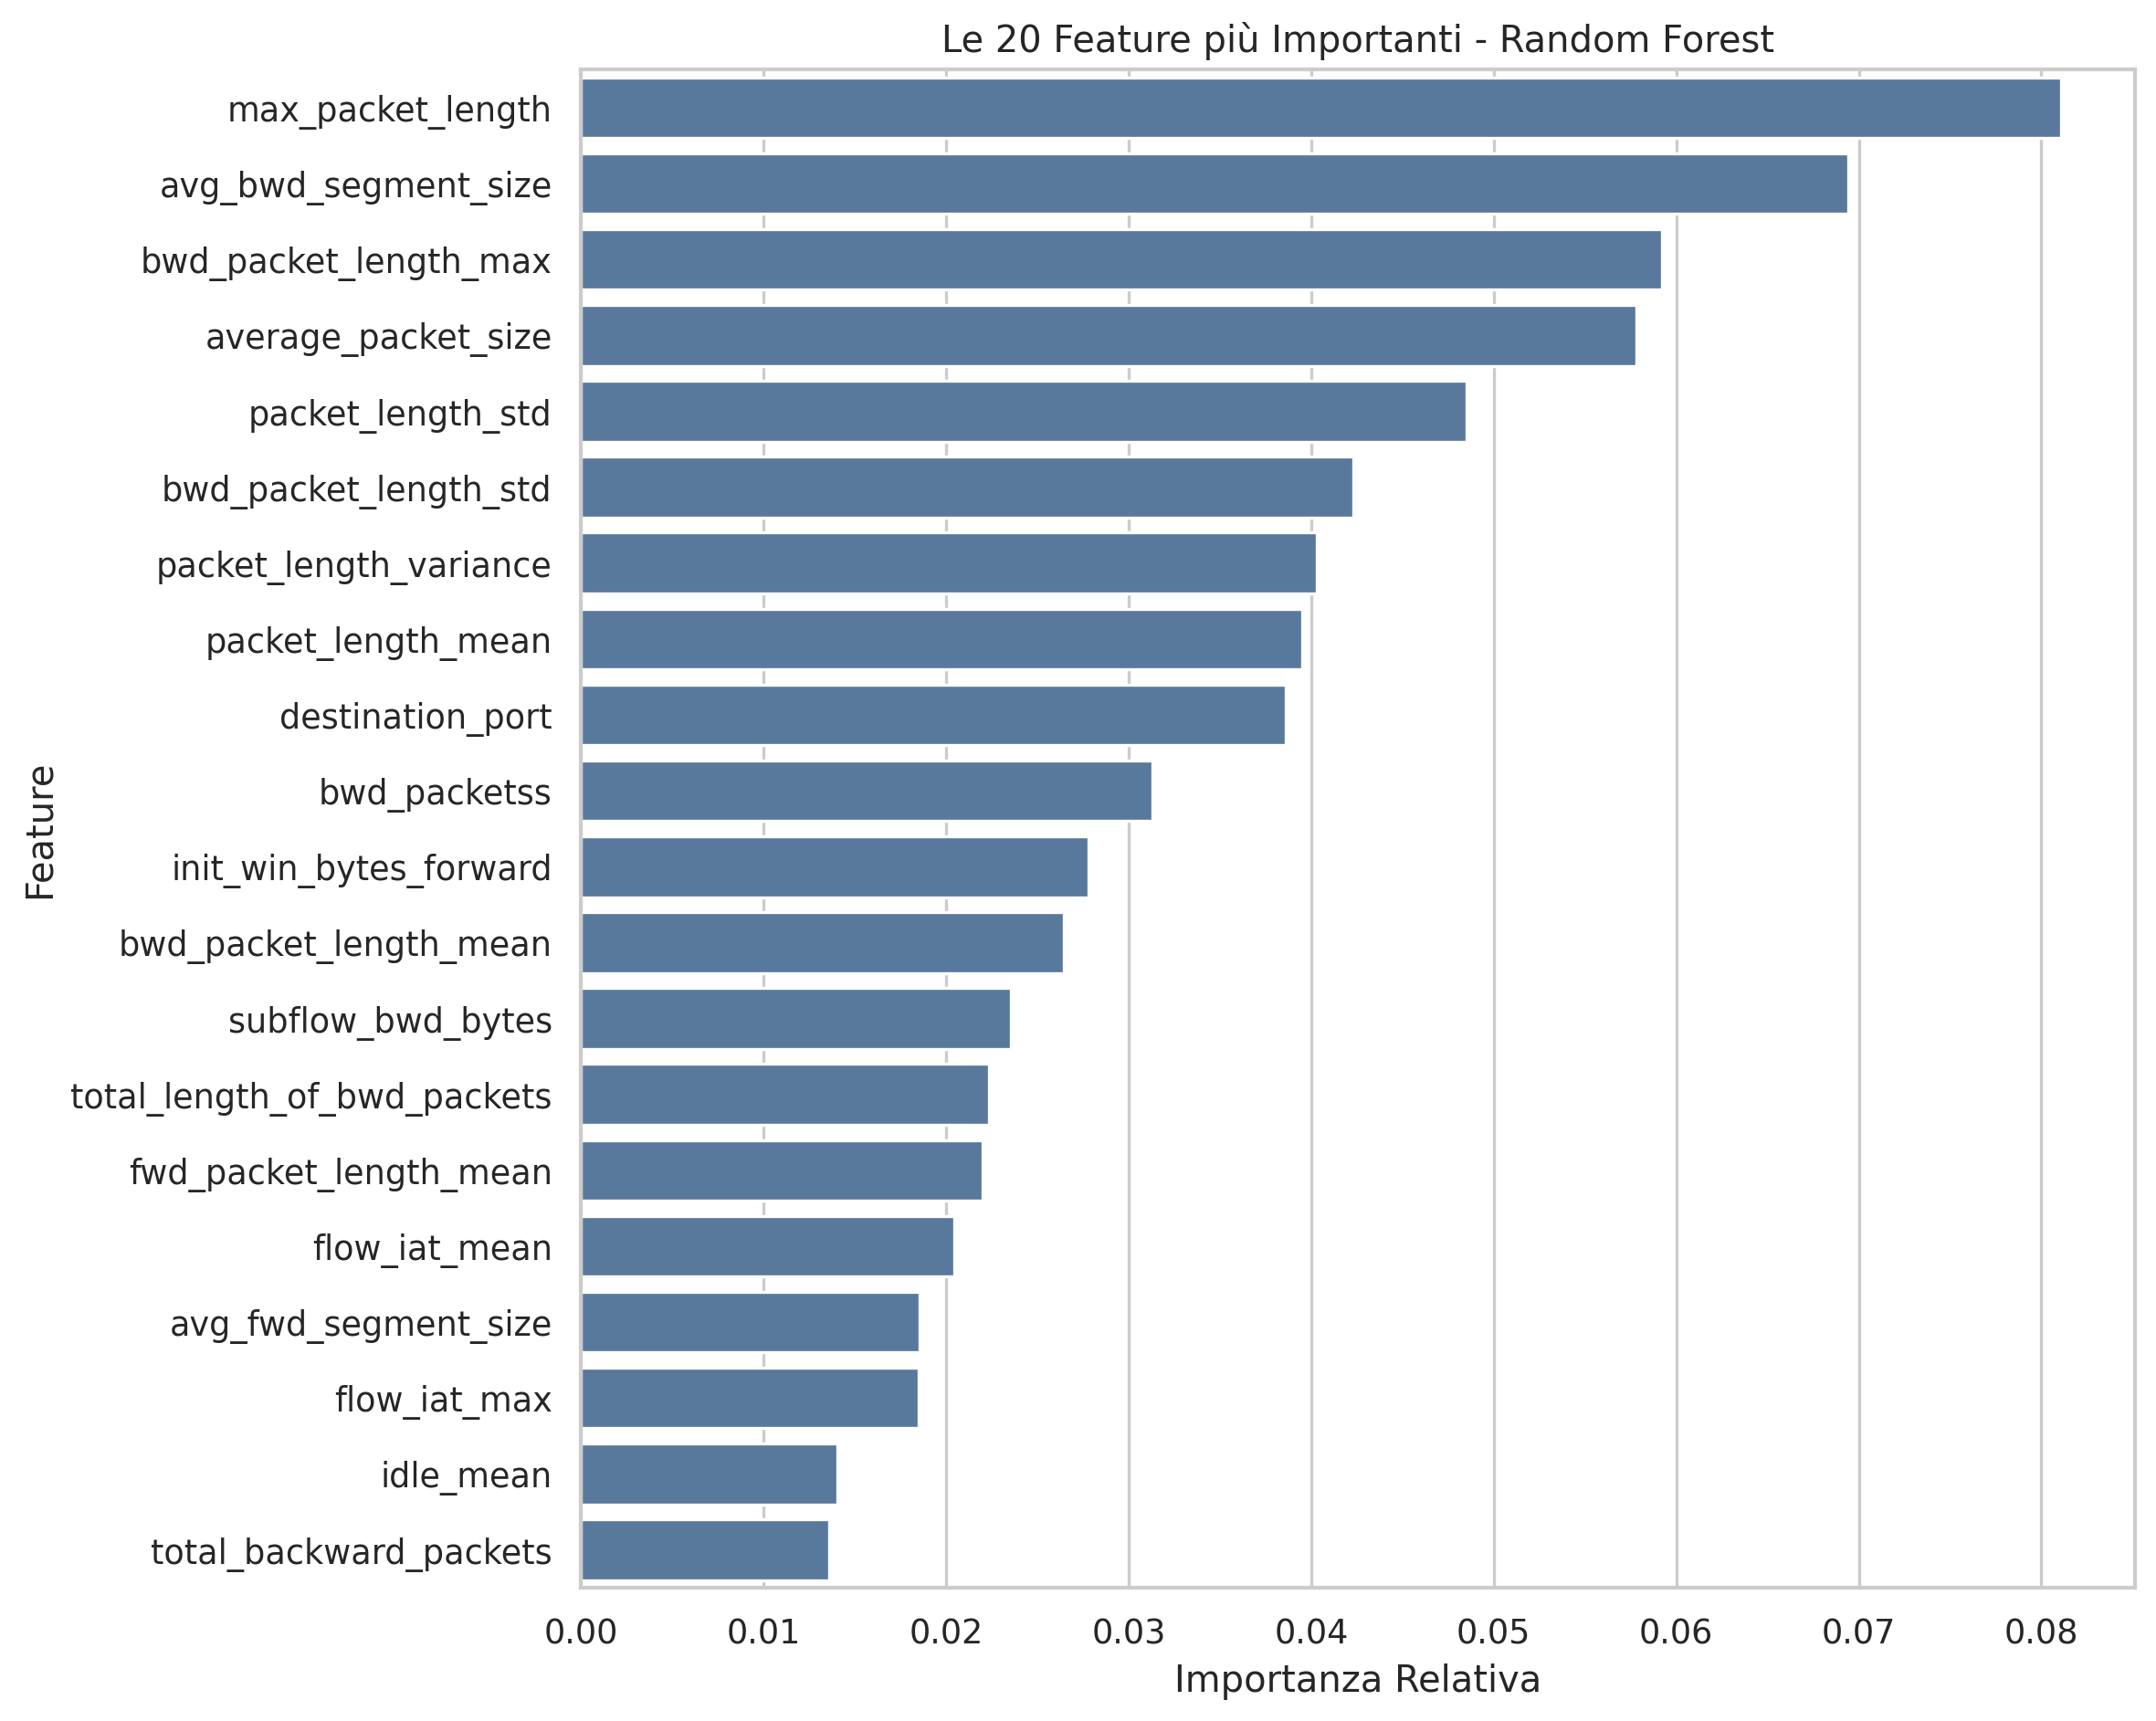

In [10]:
# ------------------------------------------------------------------------------
# 3. MODELLO 1: RANDOM FOREST (deterministica col seed)
# ------------------------------------------------------------------------------
print("\n--- Addestramento e Valutazione Random Forest ---")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=SEED,
    n_jobs=-1
)
rf_classifier.fit(X_train, y_train_str)
y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test_str, y_pred_rf)
print(f"\nAccuratezza (RF): {accuracy_rf * 100:.2f}%")
print("\nRapporto di Classificazione (RF):")
print(classification_report(y_test_str, y_pred_rf, zero_division=0))

# Matrice di Confusione RF (stesso ordine classi)
cm_rf = confusion_matrix(y_test_str, y_pred_rf, labels=class_names)
plt.figure()
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice di Confusione - Random Forest')
plt.ylabel('Classe Reale')
plt.xlabel('Classe Predetta')
plt.tight_layout()
plt.savefig("confusion_rf.png")
if IN_COLAB:
    plt.show()
plt.close()

# Importanza delle Feature RF (top-20)
feature_importances = pd.Series(rf_classifier.feature_importances_, index=pd.Index(X.columns, name="feature"))
top_20_features = feature_importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_20_features.values, y=top_20_features.index)
plt.title('Le 20 Feature più Importanti - Random Forest')
plt.xlabel('Importanza Relativa')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("rf_top20_features.png")
if IN_COLAB:
    plt.show()
plt.close()


--- Addestramento e Valutazione MLP ---

Accuratezza (MLP): 99.09%

Rapporto di Classificazione (MLP):
                  precision    recall  f1-score   support

          BENIGN       1.00      0.99      0.99      8788
   DoS GoldenEye       0.99      0.95      0.97       206
        DoS Hulk       0.98      1.00      0.99      4632
DoS Slowhttptest       0.98      0.98      0.98       111
   DoS slowloris       0.98      0.96      0.97       117

        accuracy                           0.99     13854
       macro avg       0.99      0.97      0.98     13854
    weighted avg       0.99      0.99      0.99     13854



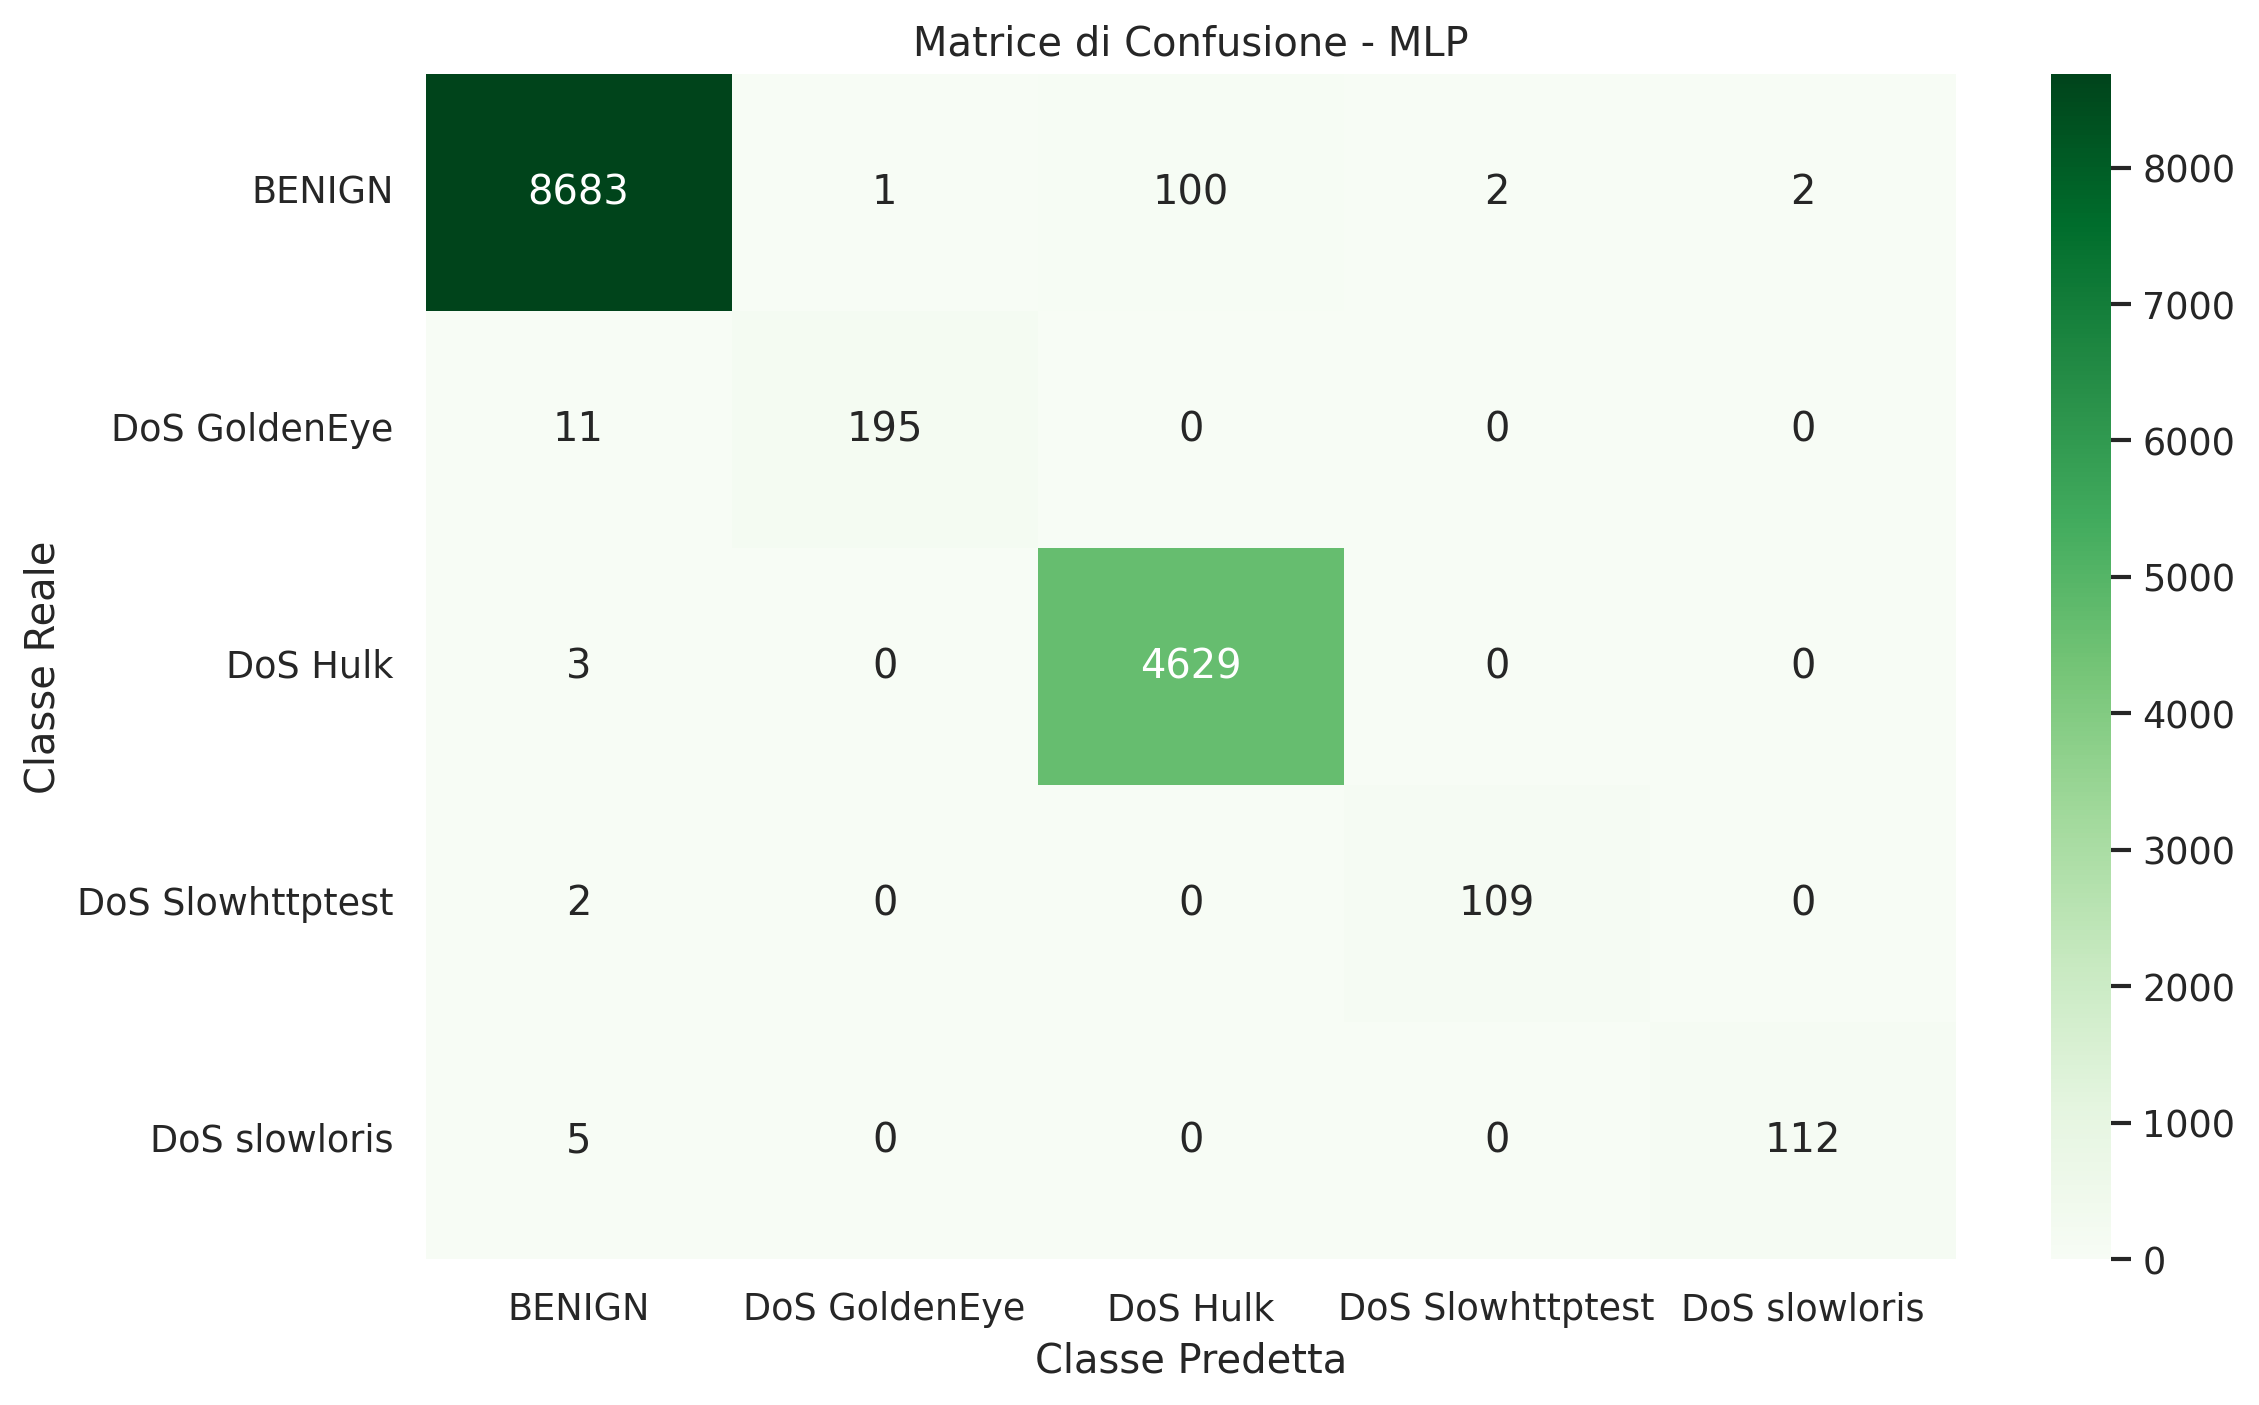

In [11]:
# ------------------------------------------------------------------------------
# 4. MODELLO 2: MLP (deterministico col seed e stessa versione sklearn)
# ------------------------------------------------------------------------------
print("\n--- Addestramento e Valutazione MLP ---")
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(50, 25),
    max_iter=300,
    random_state=SEED,       # inizializzazione pesi/shuffle deterministici
    early_stopping=True,
    verbose=False            # set True se vuoi il log
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp_classifier.fit(X_train, y_train_enc)

y_pred_mlp_enc = mlp_classifier.predict(X_test)
accuracy_mlp = accuracy_score(y_test_enc, y_pred_mlp_enc)
print(f"\nAccuratezza (MLP): {accuracy_mlp * 100:.2f}%")
print("\nRapporto di Classificazione (MLP):")
print(classification_report(y_test_enc, y_pred_mlp_enc, target_names=class_names, zero_division=0))

# Matrice di Confusione MLP con stesse etichette grafiche
cm_mlp = confusion_matrix(y_test_enc, y_pred_mlp_enc, labels=class_index)
plt.figure()
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice di Confusione - MLP')
plt.ylabel('Classe Reale')
plt.xlabel('Classe Predetta')
plt.tight_layout()
plt.savefig("confusion_mlp.png")
if IN_COLAB:
    plt.show()
plt.close()


--- Generazione Grafici di Confronto Finale ---


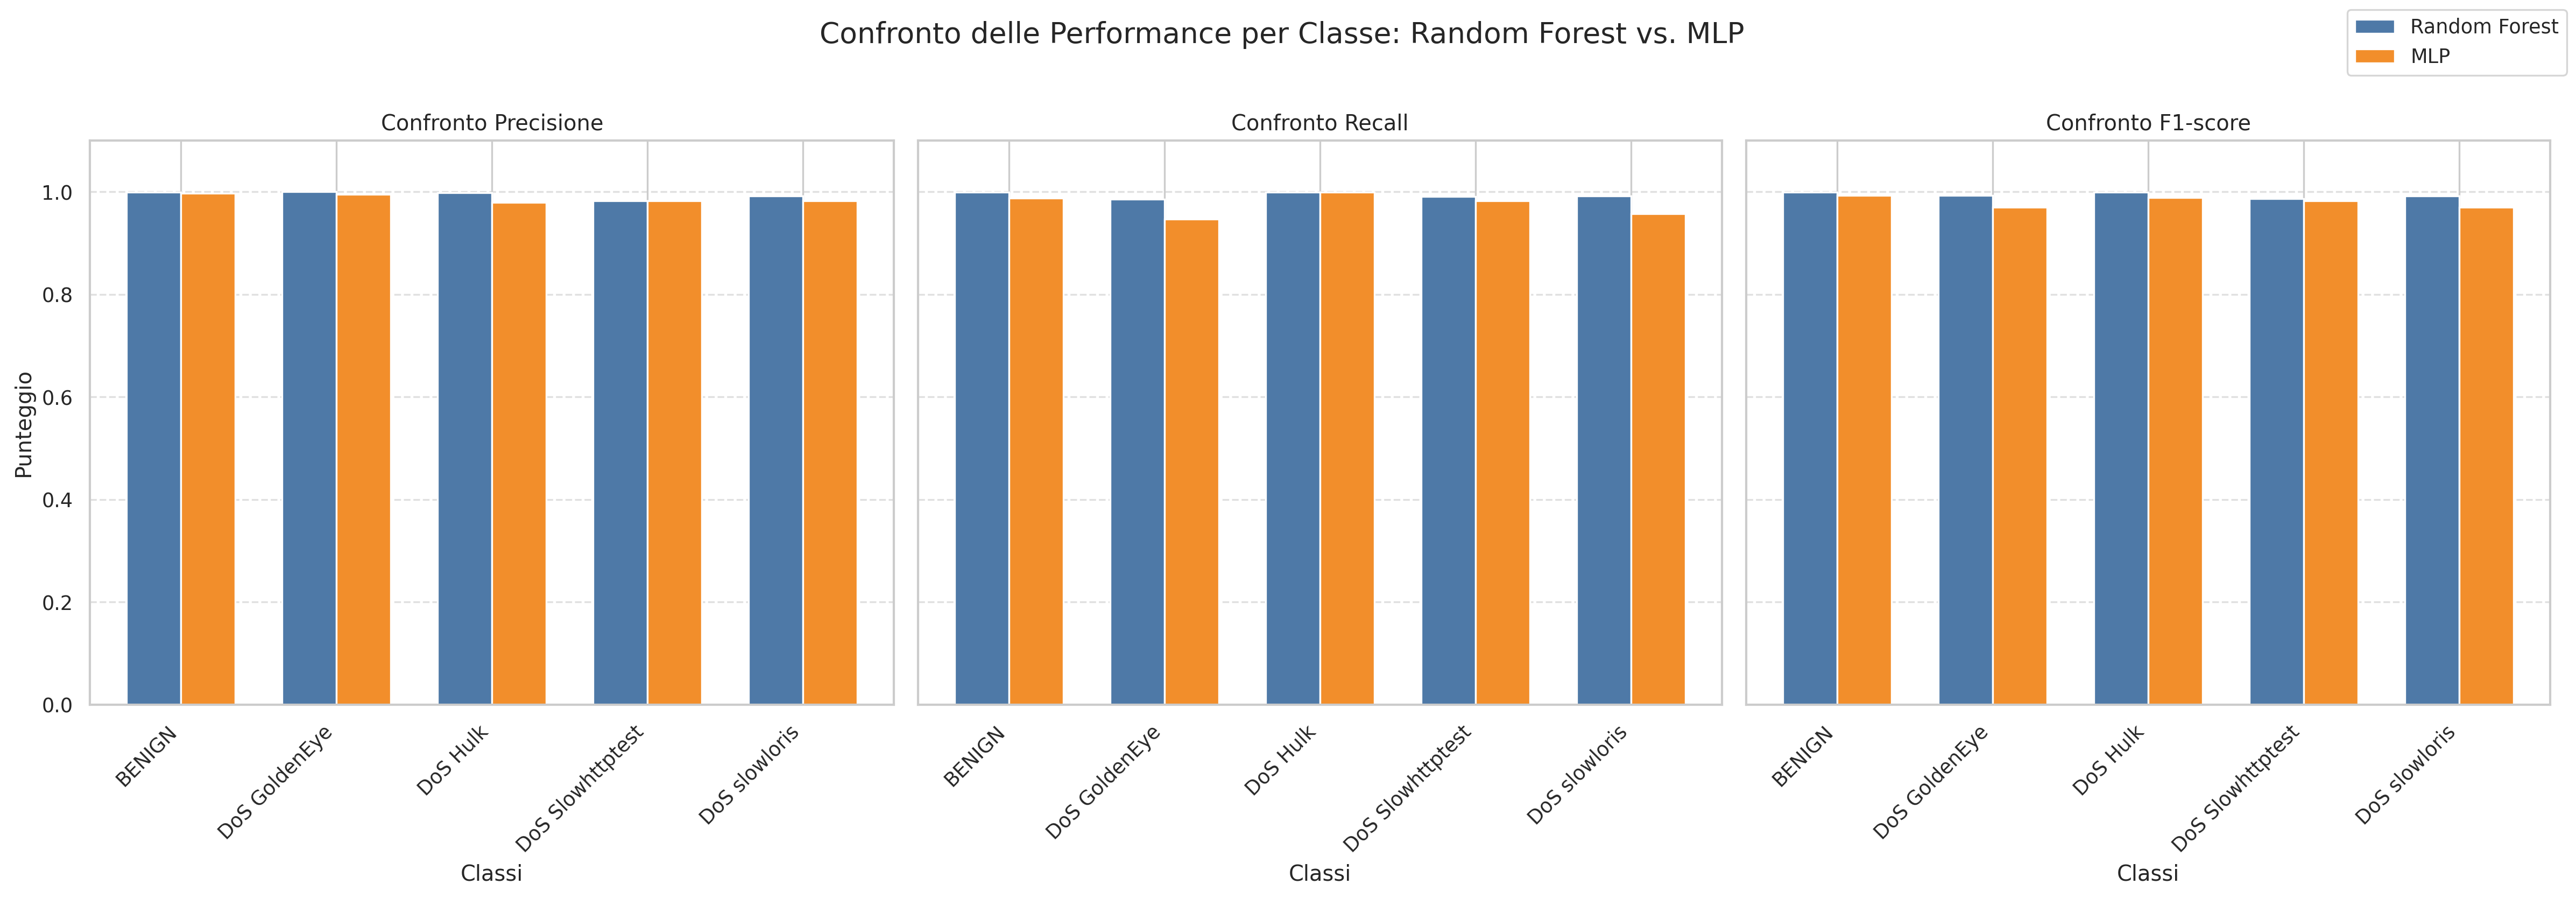

In [12]:
# ------------------------------------------------------------------------------
# 5. CONFRONTO FINALE (Precision/Recall/F1 per classe) — stessa scala e palette
# ------------------------------------------------------------------------------
print("\n--- Generazione Grafici di Confronto Finale ---")

# RF: y_test_str vs y_pred_rf su classi stringa -> metriche per ciascuna classe (nell'ordine class_names)
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(
    y_test_str, y_pred_rf, labels=class_names, zero_division=0
)

# MLP: y_test_enc vs y_pred_mlp_enc su indici -> metriche nell'ordine class_index
precision_mlp, recall_mlp, f1_mlp, _ = precision_recall_fscore_support(
    y_test_enc, y_pred_mlp_enc, labels=class_index, zero_division=0
)

x = np.arange(len(class_names))
width = 0.35

def _bar_duo(ax, vals_rf, vals_mlp, title):
    ax.bar(x - width/2, vals_rf, width, label='Random Forest')
    ax.bar(x + width/2, vals_mlp, width, label='MLP')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim(0, 1.1)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.set_xlabel('Classi')

fig, axs = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
fig.suptitle('Confronto delle Performance per Classe: Random Forest vs. MLP', fontsize=16)

_bar_duo(axs[0], precision_rf, recall_mlp*0 + precision_mlp, 'Confronto Precisione')
_bar_duo(axs[1], recall_rf,    recall_mlp,                     'Confronto Recall')
_bar_duo(axs[2], f1_rf,        f1_mlp,                         'Confronto F1-score')

axs[0].set_ylabel('Punteggio')
handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("confronto_rf_mlp.png")
if IN_COLAB:
    plt.show()
plt.close()

In [13]:
# Salvo i grafici
print("\n== File grafici salvati: ==")
print(" - confusion_rf.png")
print(" - rf_top20_features.png")
print(" - confusion_mlp.png")
print(" - confronto_rf_mlp.png")
print("\nTutto pronto: con versioni uguali di librerie, otterrai la stessa resa sia in Colab che in PyCharm.")


== File grafici salvati: ==
 - confusion_rf.png
 - rf_top20_features.png
 - confusion_mlp.png
 - confronto_rf_mlp.png

Tutto pronto: con versioni uguali di librerie, otterrai la stessa resa sia in Colab che in PyCharm.
